### Intention : The below analysis predicts the demand of shared bikes for a company called Boom Bikes. The predictors are labelled at the end of the notebook which may drive the demand of the bikes in positive or a negative manner.

#### Import libraries

In [683]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

#### Read data

In [684]:
# Load data.csv and check if data has been imported properly
data = pd.read_csv('day.csv')
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [685]:
# Check the shape of data.csv
data.shape

(730, 16)

#### Data cleanup - removing unnecessary variables

In [686]:
data = data.drop(columns=['instant',                          # This is a unique id which will not help to correlate
                          'casual',                           # This is not required as we already have the count of casual and registered
                         'registered'])                       # This is not required as we already have the count of casual and registered

In [687]:
data.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


#### Data Cleanup - Check for null values

In [688]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  cnt         730 non-null    int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 74.3+ KB


### No null values found

#### Data cleanup - Handling dte column

In [689]:
data['dteday'] = data['dteday'].apply(lambda x: int(x.split('-')[0])) # exracting only data
data = data.rename(columns={"dteday": "date"}) # renaming date column


#### Handling categorical data

In [690]:
data.season.replace({1:'spring', 2:'summer', 3:'fall', 4:'winter'},inplace = True) # Converting season to categorical type

data.weathersit.replace({1:'Clear',2:'Mist',3:'Rain',4:'Heavy Rain'},inplace = True) # converting weathersit to categorical type

data.mnth = data.mnth.replace({1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',
                  7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}) # Converting mnt to categorical type

data.weekday = data.weekday.replace({0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'}) # Converting weekday to categorical type
data.head() # read data

,date,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,spring,0,January,0,Saturday,0,Mist,14.110847,18.18125,80.5833,10.749882,985
1,2,spring,0,January,0,Sunday,0,Mist,14.902598,17.68695,69.6087,16.652113,801
2,3,spring,0,January,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,4,spring,0,January,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,5,spring,0,January,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


#### Pair plot to check the linearity 

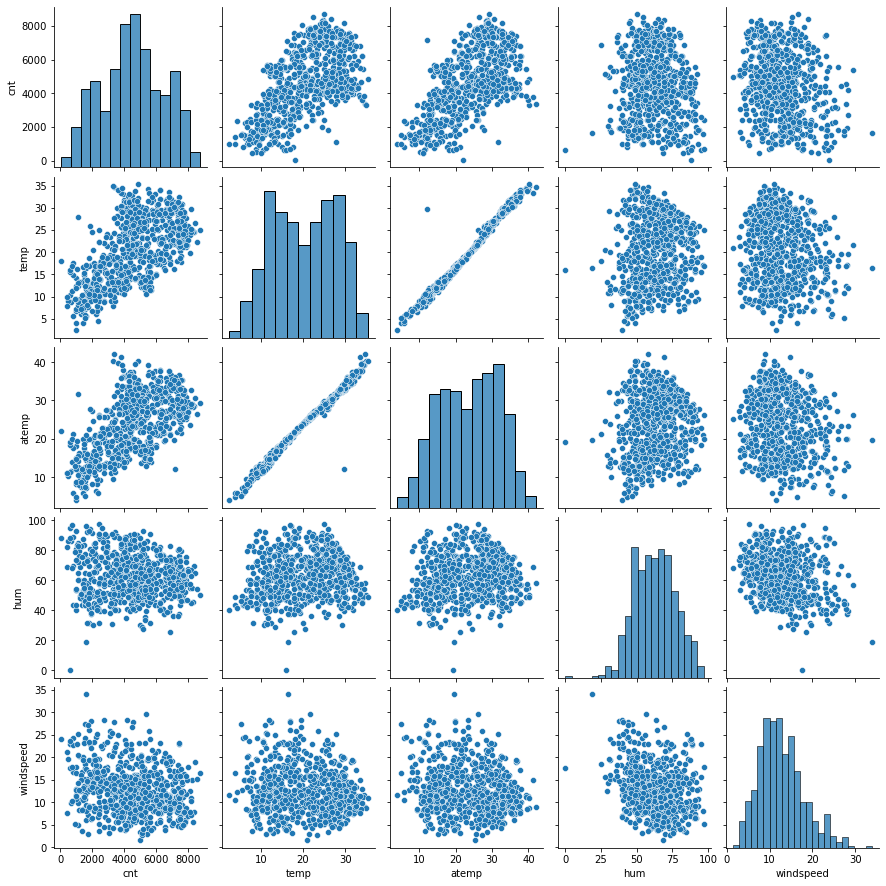

In [722]:
sns.pairplot(data=data,vars=['cnt', 'temp', 'atemp', 'hum','windspeed'])
plt.show()

#### Analyse the categorical variables with the target variable

<AxesSubplot:xlabel='season'>

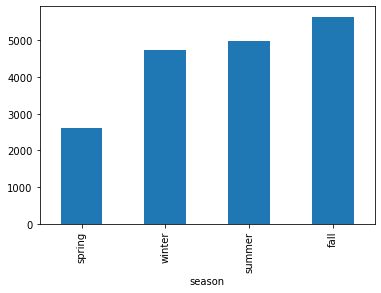

In [691]:
# Season vs Cnt
#Creating a new DF object by Grouping by season.

season_grpby = data.groupby(by='season').cnt.mean().sort_values()

# plotting on the df directly. Not using sns
season_grpby.plot(kind='bar',x='season',y='cnt')

# Inference from below graph: The ride count is different for different seasons. fall has the most ride count numbers

<AxesSubplot:xlabel='mnth'>

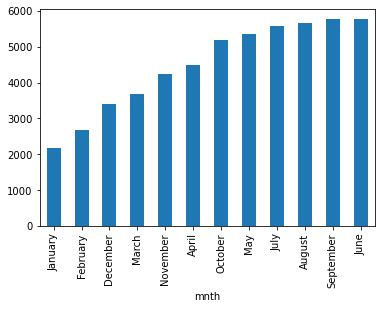

In [692]:
# Month vs Cnt
#Creating a new DF object by Grouping by Month.

month_grpby = data.groupby(by='mnth').cnt.mean().sort_values()

# plotting on the df directly. Not using sns
month_grpby.plot(kind='bar',x='mnth',y='cnt')

# Inference from below graph is that Jun and Sept have the highest demand & demand increases from may to oct. 

<AxesSubplot:xlabel='holiday'>

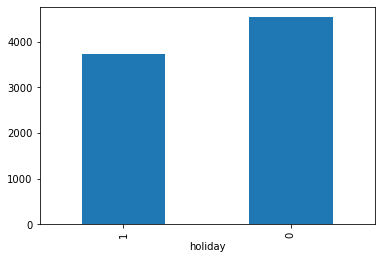

In [693]:
# Holiday vs Cnt
#Creating a new DF object by Grouping by Holiday.

holiday_grpby = data.groupby(by='holiday').cnt.mean().sort_values()

# plotting on the df directly. Not using sns
holiday_grpby.plot(kind='bar',x='holiday',y='cnt')

# Inference from below graph is that on holidays the demand is the most.

<AxesSubplot:xlabel='weekday'>

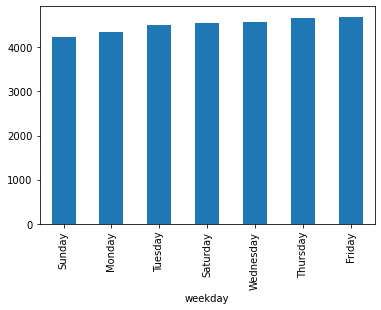

In [694]:
# Weekday vs Cnt
#Creating a new DF object by Grouping by weekday.

weekday_grpby = data.groupby(by='weekday').cnt.mean().sort_values()

# plotting on the df directly. Not using sns
weekday_grpby.plot(kind='bar',x='weekday',y='cnt')

# Inference from below graph is that friday has the most demand

<AxesSubplot:xlabel='weathersit'>

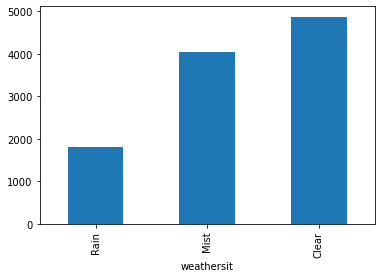

In [695]:
# Weekday vs Cnt
#Creating a new DF object by Grouping by Weather Sit.

weathersit_grpby = data.groupby(by='weathersit').cnt.mean().sort_values()

# plotting on the df directly. Not using sns
weathersit_grpby.plot(kind='bar',x='weathersit',y='cnt')

# Inference from below graph is that on clear days the demand is the most.

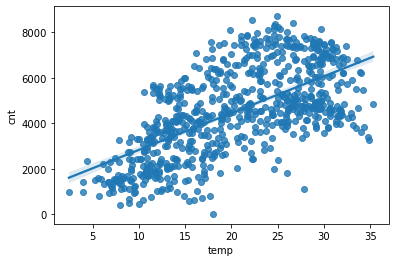

In [696]:
# Temp vs Cnt

sns.regplot(data=data,y="cnt",x="temp")
plt.show()

# below graph tells that the count increases with increase in temp.

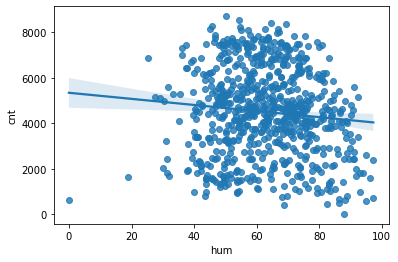

In [697]:
# Humidity Vs Cnt

sns.regplot(data=data,y="cnt",x="hum")
plt.show()

# below graph tells that the count decreases with increase in hum.

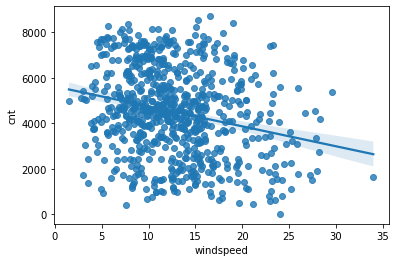

In [698]:
# Windspeed vs Cnt

sns.regplot(data=data,y="cnt",x="windspeed")
plt.show()

# below graph tells that the count decreases with increase in windspeed.

#### Creating Dummy variables

In [699]:
data = pd.get_dummies(data=data,columns=["season","mnth","weekday","weathersit"],drop_first=True)

# Show columns once dummies are created: 

data.columns

Index(['date', 'yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'cnt', 'season_spring', 'season_summer', 'season_winter',
       'mnth_August', 'mnth_December', 'mnth_February', 'mnth_January',
       'mnth_July', 'mnth_June', 'mnth_March', 'mnth_May', 'mnth_November',
       'mnth_October', 'mnth_September', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'weathersit_Mist', 'weathersit_Rain'],
      dtype='object')

In [700]:
data.head()

,date,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Mist,weathersit_Rain
0,1,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,...,0,0,0,1,0,0,0,0,1,0
1,2,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,...,0,0,0,0,1,0,0,0,1,0
2,3,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,...,0,0,1,0,0,0,0,0,0,0
3,4,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,...,0,0,0,0,0,0,1,0,0,0
4,5,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,...,0,0,0,0,0,0,0,1,0,0


#### Building the Model - Data Splitting

In [701]:
data_train, data_test = train_test_split(data, train_size=0.7, random_state=100) # splitting in a ration of 70 (train):30 (test)
data_train.shape

(510, 31)

In [702]:
data_test.shape

(220, 31)

In [703]:
data_test.columns

Index(['date', 'yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'cnt', 'season_spring', 'season_summer', 'season_winter',
       'mnth_August', 'mnth_December', 'mnth_February', 'mnth_January',
       'mnth_July', 'mnth_June', 'mnth_March', 'mnth_May', 'mnth_November',
       'mnth_October', 'mnth_September', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'weathersit_Mist', 'weathersit_Rain'],
      dtype='object')

#### Scaling data

In [704]:
# Scaling is required to make sure we can interpret the data properly
cont_vars = ['date', 'temp', 'hum', 'windspeed', 'cnt'] # note all are continous variables
scaler = MinMaxScaler()
data_train[cont_vars] = scaler.fit_transform(data_train[cont_vars])
data_train.head(10)

,date,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Mist,weathersit_Rain
576,1.000000,1,0,1,0.815169,33.14480,0.725633,0.264686,0.827658,0,...,0,0,0,0,0,0,1,0,0,0
426,0.066667,1,0,0,0.442393,20.67460,0.640189,0.255342,0.465255,1,...,0,0,0,1,0,0,0,0,1,0
728,0.966667,1,0,0,0.245101,11.58500,0.498067,0.663106,0.204096,1,...,0,0,0,0,1,0,0,0,0,0
482,0.900000,1,0,0,0.395666,18.87520,0.504508,0.188475,0.482973,0,...,0,0,0,1,0,0,0,0,1,0
111,0.700000,0,0,1,0.345824,16.09770,0.751824,0.380981,0.191095,0,...,0,0,0,0,0,0,0,0,1,0
580,0.100000,1,0,0,0.914852,37.56335,0.632030,0.462538,0.782559,0,...,0,0,0,1,0,0,0,0,0,0
500,0.500000,1,0,1,0.719639,29.79875,0.719193,0.172431,0.851588,0,...,0,0,0,0,0,0,0,1,0,0
479,0.800000,1,0,1,0.520271,23.51585,0.440962,0.164434,0.710308,0,...,0,0,0,0,0,0,0,1,0,0
472,0.566667,1,0,1,0.503656,22.85190,0.586518,0.270032,0.499885,0,...,0,0,0,0,0,0,0,1,1,0
455,0.000000,1,0,0,0.456929,20.86435,0.696865,0.279394,0.692476,0,...,0,0,0,0,1,0,0,0,1,0


#### Target and feature variables

In [705]:
y_train = data_train.pop('cnt') # Target variable count
x_train = data_train # Feature variable

#### RFE Approach to handle eliminations

In [706]:
# Lot of predictors present. Use RFE to eliminate some

lr = LinearRegression()
lr.fit(x_train, y_train)
rfe = RFE(lr, n_features_to_select=15)
rfe = rfe.fit(x_train, y_train)
rfe_df = pd.DataFrame({'Variable': x_train.columns,'Ranking': rfe.ranking_})
rfe_df.sort_values(by='Ranking')

,Variable,Ranking
14,mnth_January,1
23,weekday_Saturday,1
21,mnth_September,1
15,mnth_July,1
28,weathersit_Mist,1
10,season_winter,1
9,season_summer,1
8,season_spring,1
29,weathersit_Rain,1
6,hum,1


#### Model 1 : RFE selected variables

In [707]:
rfe_cols = x_train.columns[rfe.support_]
x_train_rfe = x_train[rfe_cols]
x_train_sm = sm.add_constant(x_train_rfe)
lr = sm.OLS(y_train, x_train_sm)
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.0
Date:                Wed, 12 Oct 2022   Prob (F-statistic):          4.22e-191
Time:                        10:47:01   Log-Likelihood:                 519.65
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     494   BIC:                            -939.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2519      0.036      6.969      0.000       0.181       0.323
yr                   0.2305      0.008     28.795      0.000       0.215       0.246
holiday             -0.0582      0.027     -2.164      0.031      -0.111      -0.005
workingday           0.0433      0.012      3.762      0.000       0.021       0.066
temp                 0.5096      0.034     14.837      0.000       0.442       0.577
hum                 -0.1563      0.037     -4.188      0.000      -0.230      -0.083
windspeed           -0.1863      0.025     -7.310      0.000      -0.236      -0.136
season_spring       -0.0509      0.021     -2.464      0.014      -0.091      -0.010
season_summer        0.0508      0.015      3.423      0.001       0.022       0.080
season_winter        0.0933      0.017      5.403      0.000       0.059       0.127
mnth_January        -0.0345      0.017     -1.989      0.047      -0.069      -0.000
mnth_July           -0.0529      0.018     -2.931      0.004      -0.088      -0.017
mnth_September       0.0814      0.016      4.945      0.000       0.049       0.114
weekday_Saturday     0.0536      0.014      3.694      0.000       0.025       0.082
weathersit_Mist     -0.0563      0.010     -5.439      0.000      -0.077      -0.036
weathersit_Rain     -0.2475      0.026     -9.507      0.000      -0.299      -0.196
==============================================================================
Omnibus:                       66.260   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.826
Skew:                          -0.678   Prob(JB):                     1.97e-35
Kurtosis:                       5.383   Cond. No.                         22.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Fetching VIF

In [708]:
vif_data = pd.DataFrame()
vif_data['Features'] = x_train_rfe.columns
vif_data['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif_data['VIF'] = round(vif_data['VIF'], 2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)
vif_data = vif_data.reset_index(drop=True)
vif_data

,Features,VIF
0,hum,29.37
1,temp,17.78
2,workingday,5.31
3,windspeed,4.73
4,season_spring,4.53
5,season_winter,3.46
6,season_summer,2.85
7,weathersit_Mist,2.29
8,yr,2.09
9,weekday_Saturday,1.98


##### From above table we see p values are already under control and none of them are >0.05. From VIF table we see that humidity is already explained by other feature. Dropping this column.

#### Model 2 - based on removal of hum

In [709]:
rfe_cols = rfe_cols.drop(['hum'])
x_train_rfe = x_train[rfe_cols]
x_train_sm = sm.add_constant(x_train_rfe)
lr = sm.OLS(y_train, x_train_sm)
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     189.6
Date:                Wed, 12 Oct 2022   Prob (F-statistic):          1.60e-188
Time:                        10:47:01   Log-Likelihood:                 510.75
No. Observations:                 510   AIC:                            -991.5
Df Residuals:                     495   BIC:                            -928.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1737      0.031      5.520      0.000       0.112       0.235
yr                   0.2345      0.008     29.009      0.000       0.219       0.250
holiday             -0.0558      0.027     -2.042      0.042      -0.109      -0.002
workingday           0.0464      0.012      3.966      0.000       0.023       0.069
temp                 0.4722      0.034     14.005      0.000       0.406       0.538
windspeed           -0.1563      0.025     -6.286      0.000      -0.205      -0.107
season_spring       -0.0599      0.021     -2.867      0.004      -0.101      -0.019
season_summer        0.0445      0.015      2.967      0.003       0.015       0.074
season_winter        0.0784      0.017      4.562      0.000       0.045       0.112
mnth_January        -0.0392      0.018     -2.227      0.026      -0.074      -0.005
mnth_July           -0.0479      0.018     -2.614      0.009      -0.084      -0.012
mnth_September       0.0755      0.017      4.527      0.000       0.043       0.108
weekday_Saturday     0.0583      0.015      3.968      0.000       0.029       0.087
weathersit_Mist     -0.0813      0.009     -9.437      0.000      -0.098      -0.064
weathersit_Rain     -0.2908      0.024    -11.977      0.000      -0.339      -0.243
==============================================================================
Omnibus:                       67.830   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.565
Skew:                          -0.692   Prob(JB):                     1.84e-36
Kurtosis:                       5.415   Cond. No.                         20.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [710]:
vif_data = pd.DataFrame()
vif_data['Features'] = x_train_rfe.columns
vif_data['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif_data['VIF'] = round(vif_data['VIF'], 2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)
vif_data = vif_data.reset_index(drop=True)
vif_data

,Features,VIF
0,temp,7.07
1,workingday,5.24
2,windspeed,4.68
3,season_spring,3.07
4,season_summer,2.34
5,yr,2.08
6,season_winter,1.98
7,weekday_Saturday,1.97
8,mnth_January,1.62
9,mnth_July,1.59


#### Model 3: Removing vars with p values >0 and remodelling

In [711]:
rfe_cols = rfe_cols.drop(['mnth_January','mnth_July','workingday'])

x_train_rfe = x_train[rfe_cols]
x_train_sm = sm.add_constant(x_train_rfe)
lr = sm.OLS(y_train, x_train_sm)
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     226.9
Date:                Wed, 12 Oct 2022   Prob (F-statistic):          5.55e-186
Time:                        10:47:01   Log-Likelihood:                 496.34
No. Observations:                 510   AIC:                            -968.7
Df Residuals:                     498   BIC:                            -917.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1874      0.030      6.327      0.000       0.129       0.246
yr                   0.2346      0.008     28.330      0.000       0.218       0.251
holiday             -0.0930      0.026     -3.540      0.000      -0.145      -0.041
temp                 0.4790      0.033     14.485      0.000       0.414       0.544
windspeed           -0.1501      0.025     -5.938      0.000      -0.200      -0.100
season_spring       -0.0552      0.021     -2.647      0.008      -0.096      -0.014
season_summer        0.0625      0.014      4.389      0.000       0.035       0.091
season_winter        0.0945      0.017      5.640      0.000       0.062       0.127
mnth_September       0.0909      0.016      5.572      0.000       0.059       0.123
weekday_Saturday     0.0195      0.011      1.710      0.088      -0.003       0.042
weathersit_Mist     -0.0788      0.009     -8.965      0.000      -0.096      -0.062
weathersit_Rain     -0.2855      0.025    -11.484      0.000      -0.334      -0.237
==============================================================================
Omnibus:                       69.512   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.038
Skew:                          -0.748   Prob(JB):                     2.63e-33
Kurtosis:                       5.197   Cond. No.                         17.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [712]:
vif_data = pd.DataFrame()
vif_data['Features'] = x_train_rfe.columns
vif_data['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif_data['VIF'] = round(vif_data['VIF'], 2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)
vif_data = vif_data.reset_index(drop=True)
vif_data

,Features,VIF
0,windspeed,4.62
1,temp,3.87
2,yr,2.07
3,season_spring,2.01
4,season_summer,1.90
5,season_winter,1.64
6,weathersit_Mist,1.55
7,mnth_September,1.23
8,weekday_Saturday,1.19
9,weathersit_Rain,1.08


#### Model 4: Removing Saturday due to high p value

In [713]:
rfe_cols = rfe_cols.drop(['weekday_Saturday'])

x_train_rfe = x_train[rfe_cols]
x_train_sm = sm.add_constant(x_train_rfe)
lr = sm.OLS(y_train, x_train_sm)
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     248.4
Date:                Wed, 12 Oct 2022   Prob (F-statistic):          1.47e-186
Time:                        10:47:01   Log-Likelihood:                 494.84
No. Observations:                 510   AIC:                            -967.7
Df Residuals:                     499   BIC:                            -921.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1909      0.030      6.447      0.000       0.133       0.249
yr                  0.2341      0.008     28.237      0.000       0.218       0.250
holiday            -0.0963      0.026     -3.668      0.000      -0.148      -0.045
temp                0.4777      0.033     14.423      0.000       0.413       0.543
windspeed          -0.1481      0.025     -5.854      0.000      -0.198      -0.098
season_spring      -0.0554      0.021     -2.654      0.008      -0.096      -0.014
season_summer       0.0621      0.014      4.350      0.000       0.034       0.090
season_winter       0.0945      0.017      5.630      0.000       0.062       0.127
mnth_September      0.0910      0.016      5.566      0.000       0.059       0.123
weathersit_Mist    -0.0787      0.009     -8.938      0.000      -0.096      -0.061
weathersit_Rain    -0.2850      0.025    -11.444      0.000      -0.334      -0.236
==============================================================================
Omnibus:                       63.413   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.384
Skew:                          -0.674   Prob(JB):                     1.21e-31
Kurtosis:                       5.210   Cond. No.                         17.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [714]:
vif_data = pd.DataFrame()
vif_data['Features'] = x_train_rfe.columns
vif_data['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif_data['VIF'] = round(vif_data['VIF'], 2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)
vif_data = vif_data.reset_index(drop=True)
vif_data

,Features,VIF
0,windspeed,4.60
1,temp,3.84
2,yr,2.07
3,season_spring,1.99
4,season_summer,1.90
5,season_winter,1.63
6,weathersit_Mist,1.55
7,mnth_September,1.23
8,weathersit_Rain,1.08
9,holiday,1.04


#### The above tables has the p values and VIF all in control. Looks good. 

#### Model Evaluation

##### Residual

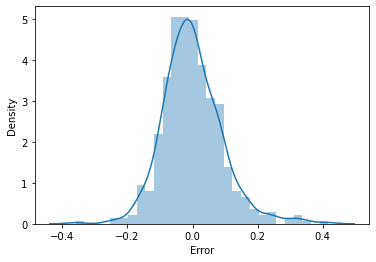

In [715]:
y_train_var = lr_model.predict(x_train_sm)
residual_analysis = y_train_var - y_train
sns.distplot(residual_analysis)
plt.xlabel('Error')
plt.show()

# Below graph shows that the error distribution is distrubuted across 0. Model has handled the assumption of error normal distubution

##### Error terms being Independent

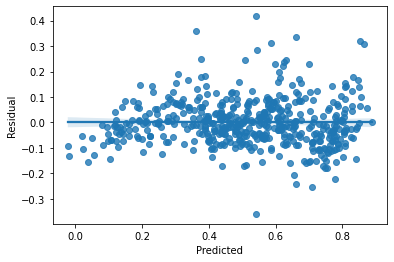

In [716]:
sns.regplot(x=y_train_var, y=residual_analysis)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

#Below graph shows no pattern between residual and predicted values as is signified by the line. 

##### Predicted vs Actual

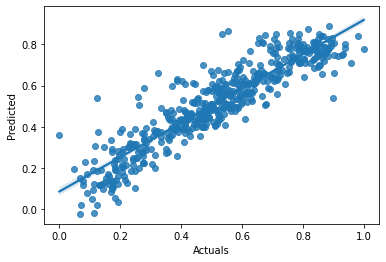

In [717]:
sns.regplot(x=y_train, y=y_train_var)
plt.xlabel('Actuals')
plt.ylabel('Predicted')
plt.show()

# Below graph shows that the predicted and actual are equally distributed

### Test data predictions

In [718]:
data_test[cont_vars] = scaler.transform(data_test[cont_vars])
data_test.head(10)

,date,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Mist,weathersit_Rain
184,0.100000,0,1,0,0.831783,33.27085,0.657364,0.084219,0.692706,0,...,0,0,1,0,0,0,0,0,1,0
535,0.633333,1,0,1,0.901354,36.04875,0.610133,0.153728,0.712034,0,...,0,0,0,0,0,0,0,1,0,0
299,0.866667,0,0,1,0.511964,22.85230,0.837699,0.334206,0.303382,0,...,1,0,0,0,0,1,0,0,1,0
221,0.300000,0,0,1,0.881625,34.24915,0.437098,0.339570,0.547400,0,...,0,0,0,0,0,0,0,1,0,0
152,0.033333,0,0,1,0.817246,32.19710,0.314298,0.537414,0.569029,0,...,0,0,0,0,0,1,0,0,0,0
404,0.266667,1,0,1,0.256524,13.09940,0.579218,0.326196,0.438104,1,...,0,0,0,0,0,1,0,0,0,0
198,0.566667,0,0,1,0.856704,35.19625,0.671103,0.372990,0.510354,0,...,0,0,1,0,0,0,0,0,0,0
171,0.666667,0,0,1,0.774672,31.88230,0.793903,0.276724,0.553728,0,...,0,0,0,0,0,0,1,0,1,0
512,0.900000,1,1,0,0.814131,33.96500,0.696865,0.331536,0.692706,0,...,0,0,1,0,0,0,0,0,0,0
200,0.633333,0,0,1,0.883701,37.34250,0.728638,0.153738,0.495858,0,...,0,0,0,0,0,0,0,1,0,0


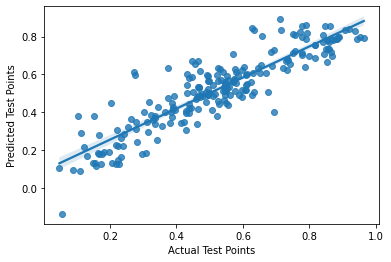

In [719]:
y_test = data_test.pop("cnt") # Test target variable
x_test = data_test # Test feature variable

# Filtering test input
x_test_filter = x_test[x_train_rfe.columns]
x_test_filter = sm.add_constant(x_test_filter)

# Predicting test data
y_test_pred = lr_model.predict(x_test_filter)

#Plotting predicted test points vs actual test points
corr_plot = sns.regplot(x=y_test, y=y_test_pred)
plt.xlabel('Actual Test Points')
plt.ylabel('Predicted Test Points')
plt.show()

# Below graph shows perfect linear relationship between predicted and actual

#### Observations and Analysis

In [720]:
# Based on the final model below are the observations: 

#temp: A coefficient value of 0.4777 indicated that a unit increase in temp variable, 
#increases the bike hire numbers by 0.4722 units.

#weathersit_rain: A coefficient value of -0.2908 indicated that a unit increase in Weathersit rain variable, 
#decreases the bike hire numbers by 0.2908 units.

#yr: A coefficient value of 0.2341 indicated that a unit increase in yr variable,
#increases the bike hire numbers by 0.2341 units.

#season_winter: A coefficient value of 0.0945 indicated that,
#a unit increase in season_winter variable increases the bike hire numbers by 0.0784 units.

#windspeed: A coefficient value of -0.1481 indicated that,a unit increase in windspeed variable 
#decreases the bike hire numbers by 0.1563 units.

